In [194]:
# !pip install qiskit pylatexenc qiskit-aer

### **Grover’s Algorithm**

<br>

Grover’s search algorithm finds a marked item in an unsorted database of size $N = 2^n$ using only $O(\sqrt{N})$ queries.

In this tutorial, we implement Grover entirely from scratch:
1. Build the oracle manually
2. Build the diffuser manually
3. Run on AerSimulator
4. Verify that the correct marked state appears with highest probability

---


In [195]:
import qiskit
import qiskit_aer

print(qiskit.__version__)
print(qiskit_aer.__version__)

2.2.3
0.17.2



##### **1. Problem Setup**

<br>

We choose:
* **Number of qubits:** $n$
* **Target item to search:** represented as a bitstring,
    <br>for example:
    $$101_2 = 5$$
    This means we want Grover to mark the state $|101\rangle$.

---


In [196]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

num = 14
n_of_qubits = 4
bitstring = format(num, f"0{n_of_qubits}b")[::-1]
print(f'bitsting : {bitstring}')

bitsting : 0111



##### **2. How the Oracle Works**

<br>

Grover’s oracle applies:
$$U_f = I - 2|w\rangle\langle w|$$
This flips the phase only of the target state.

**Oracle construction steps:**
1.  **Flip all qubits** where the target bit = 0
    $\rightarrow$ This maps the target $|w\rangle$ to $|11\ldots1\rangle$.
2.  **Apply an $n$-controlled Z** (phase flip on $|11\ldots1\rangle$).
3.  **Undo** the initial X-gates.

This marks the target state with a $-1$ phase.

---

##### **2.1 Multi-Controlled Z Implementation**

<br>

Qiskit supports `MCX` (multi-controlled X).

To convert an `MCX` into `MCZ`:
1.  Apply $H$ on target
2.  Apply `MCX`
3.  Apply $H$ again

This effectively produces the $n$-controlled Z gate.

---


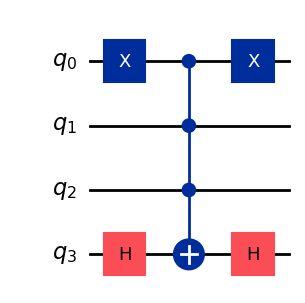

In [197]:
# -------------------------
# build grover oracle
# -------------------------


def build_oracle(bitstring, n_of_qubits):
  qc = QuantumCircuit(n_of_qubits)
  # 2. flip qubits where bit == 0
  for i, bit in enumerate(bitstring):
    if bit == '0':
      qc.x(i)

  # 3. Apply MCZ
  qc.h(n_of_qubits - 1)
  qc.mcx(list(range(n_of_qubits - 1)), n_of_qubits - 1)
  qc.h(n_of_qubits - 1)

  # 3. undo flip
  for i, bit in enumerate(bitstring):
    if bit == '0':
      qc.x(i)
  return qc

g_oracle = build_oracle(bitstring, n_of_qubits).to_gate()
g_oracle.name='U_f'
g_oracle.definition.draw("mpl")


##### **3. The Diffuser (Inversion About the Mean)**

<br>

The diffuser performs:
$$D = 2|s\rangle\langle s| - I$$

**Steps:**
1.  Apply $H$ to all qubits
2.  Apply $X$ to all qubits
3.  Apply multi-controlled $Z$
4.  Apply $X$ to all qubits
5.  Apply $H$ to all qubits

This amplifies the amplitude of the marked state after the oracle.

---


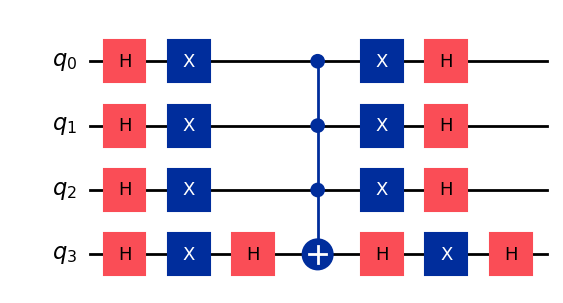

In [198]:
def build_diffuser(n):
  qc = QuantumCircuit(n)
  for i in range(n):
    qc.h(i)
    qc.x(i)

  qc.h(n-1)
  qc.mcx(list(range(n-1)), n-1)
  qc.h(n-1)

  for i in range(n):
    qc.x(i)
    qc.h(i)
  return qc

diffuser = build_diffuser(n_of_qubits).to_gate()
diffuser.name = 'U_s'
diffuser.definition.draw("mpl")


##### **4. Running Grover’s Algorithm**

<br>

**Steps in the circuit:**
1.  Start all qubits in $|0\rangle$
2.  Apply $H$ on all qubits $\rightarrow$ equal superposition
3.  Apply the **Oracle**
4.  Apply the **Diffuser**
5.  Measure all qubits
6.  Run on `AerSimulator`

---


Grover iterations = 3


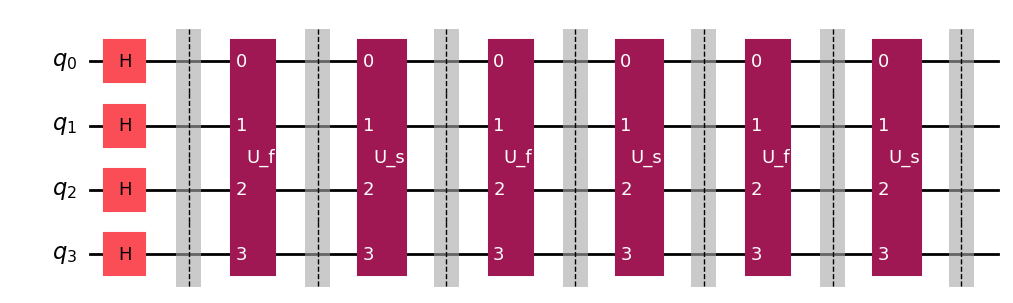

In [199]:
import math

qc = QuantumCircuit(n_of_qubits)

# 1. Create equal superposition
for i in range(n_of_qubits):
    qc.h(i)

qc.barrier()

# Number of Grover iterations for 6 qubits
iterations = math.floor(math.pi * math.sqrt(2 ** n_of_qubits) / 4)
print("Grover iterations =", iterations)

for _ in range(iterations):

    # 2. Apply Oracle
    qc.append(g_oracle, range(n_of_qubits))
    qc.barrier()

    # 3. Apply Diffuser
    qc.append(diffuser, range(n_of_qubits))
    qc.barrier()

qc.draw("mpl")


In [200]:
Statevector(qc).draw('latex')

<IPython.core.display.Latex object>

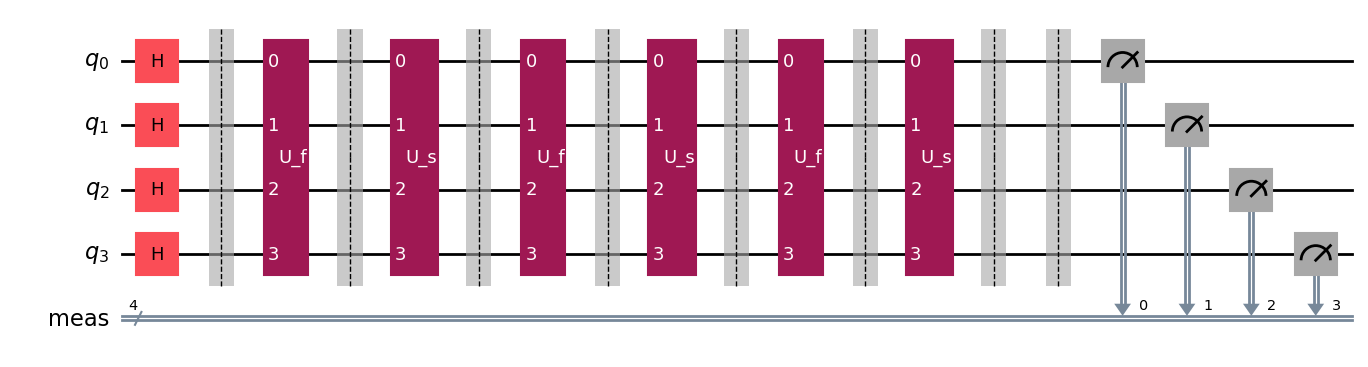

In [201]:
qc.measure_all()
qc.draw("mpl")


##### **5. Expected Output**

<br>

If everything is correct, the histogram will show:
* The marked state (e.g., `101`) has the **highest probability**.
* Other states appear with small probability due to noise-free simulation.

This demonstrates Grover’s quadratic speedup.

---


<br>

**simulation on AerSimulator**

---

{'1100': 2, '0001': 1, '1110': 985, '1101': 2, '1011': 4, '0111': 3, '0011': 3, '0000': 2, '0010': 2, '0101': 2, '1001': 4, '0110': 3, '1000': 3, '0100': 1, '1010': 3, '1111': 4}


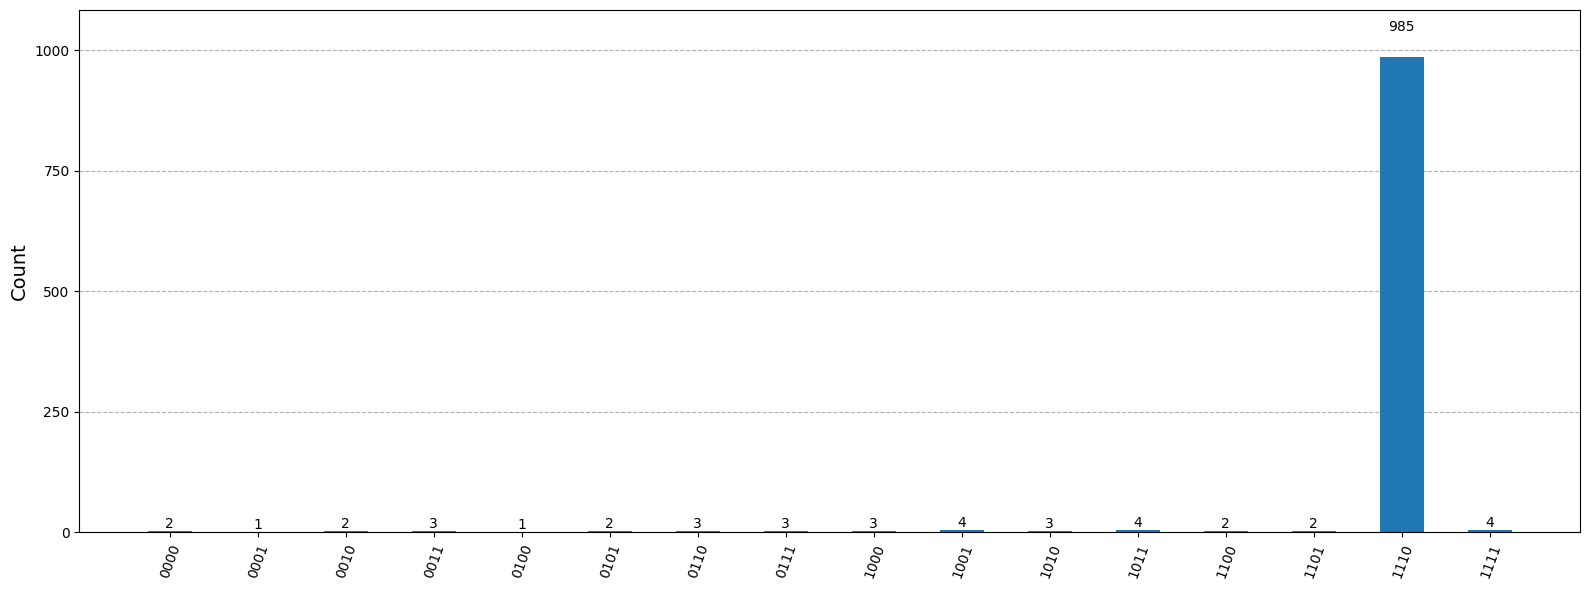

In [202]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

sim = AerSimulator()
transpiled_circuit = transpile(qc, sim)
job = sim.run(transpiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts()

print(counts)
plot_histogram(counts, figsize=(16, 6))


<br>

**simulation on custom built noise model**

---

In [203]:
# ------------------------------
# 1. BUILD CUSTOM NOISE MODEL
# ------------------------------


from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error, thermal_relaxation_error

noise_model = NoiseModel()

depol_1q = 0.005      # 0.5% 1-qubit depolarizing noise
depol_2q = 0.02       # 2%   2-qubit depolarizing noise
t1 = 50e3             # T1 = 50 microseconds
t2 = 70e3             # T2 = 70 microseconds
gate_time_1q = 100    # 100 ns
gate_time_2q = 300    # 300 ns

# Add 1-qubit depolarizing noise
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(depol_1q, 1),
    ['x', 'h', 'z']
)

# Add 2-qubit noise
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(depol_2q, 2),
    ['cx']
)

# Add relaxation noise (thermal relaxation)
therm_relax_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
therm_relax_2q = thermal_relaxation_error(t1, t2, gate_time_2q).tensor(
    thermal_relaxation_error(t1, t2, gate_time_2q)
)

noise_model.add_all_qubit_quantum_error(therm_relax_1q, ['x', 'h', 'z'])
noise_model.add_all_qubit_quantum_error(therm_relax_2q, ['cx'])



counts: {'0010': 109, '0001': 107, '1010': 121, '1110': 328, '1111': 120, '1011': 112, '0011': 114, '0111': 126, '1101': 114, '0000': 93, '0110': 131, '1000': 102, '1100': 127, '0101': 118, '1001': 106, '0100': 120}


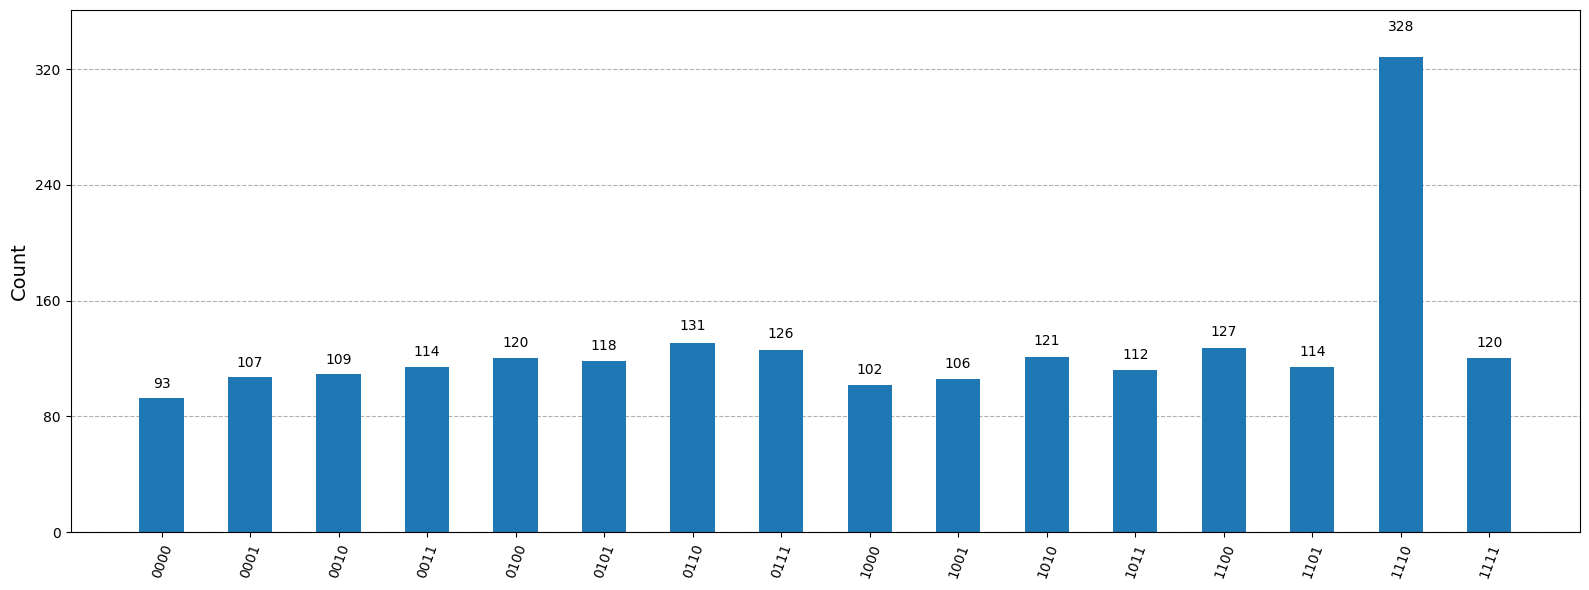

In [204]:


sim_noise = AerSimulator(noise_model=noise_model)

compiled = transpile(qc, sim_noise)
job = sim_noise.run(compiled, shots=2048)
result = job.result()
counts = result.get_counts()
print("\ncounts:", counts)

plot_histogram(counts, figsize=(16, 6))
